# Predicting Player Performance for Fantasy Baseball
*Allyson Tom, Drew Pearson, Jacob Adams*

## Introduction

Fantasy sports are the closest thing most fans can get to being the general manager of a team. The following of fantasy sports has grown to over 50 million people (U.S. & Canada). Fantasy baseball was the first fantasy sport created and will be the focus of this project. For those who are unfamiliar with fantasy sports, the format is as follows. People enter leagues with 5-15 other participants. The league participants then draft real professional players to fill their rosters. Based on how those professional players perform in real life, the fantasy participants receive points, with the goal being to get more points than the other people in their league. Thus, the key to having a good team is a successful draft and the key to a successful draft is predicting how players will perform in the upcoming season.

Our goal is to create the most accurate set of predictions. This set of predictions will be a combination of predictions from 6 other entities (ESPN, Marcel, CBS, Guru, Steamer, and FanGraphs). These entities make predictions for each season, but we will show later that their predictions for a given statistic are only correct at 50% of the time, at best. We use machine learning classifiers to determine which of the predictions has the highest probability of being correct by using the players previous years statistics. Then, we combine these correct predictions into one dataset, which is our new and improved set of predictions. Our set of predictions is on average 10-15% more accurate than any of the six methods mentioned above, which serves as a powerful tool for deciding who to draft. 

The data used in this project are:

- Actual statistics for MLB players from the 2009-2016 regular seasons, split by hitting and pitching statistics
- Statistical projections from 2010-2017 for MLB player performance by ESPN, Marcel, CBS, Guru, Steamer, and FanGraphs, split by hitting and pitching projections


Questions we would like to answer include:
- Can we use various machine learning classifiers to determine when a given prediction will be correct?
- Can we combine all the correct predictions to create a new set of predictions that is more accurate than the individual prediction methods?

Note: A majority of the code used in this project is not included directly in this notebook, but is provided in various helper .py files that we clearly reference throughout the project. 


In [15]:
from __future__ import division
import voting_classifier
import accuracy_lists, optimal_parameters
import box_plots, player_comparison, correct_predictions
import new_ML
import new_set_of_predictions
import pandas as pd
import re
import numpy as np
import os
from operator import itemgetter, truediv
import collections
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

We essentially create and use two datasets: actual statistics and predicted statistics. Actual statistics were obtained from MLB.com. Predicted statistics were obtained from each of the sources independently: ESPN data from espn.com, CBS data from cbs.com, etc. We use batting average (AVG or BA), homeruns (HR), runs (R), runs-batted-in (RBI), and stolen bases (SB) as the statistics of prediction interest for hitters. We use earned run average (ERA), wins (W), strikeouts (SO or K), and walks plus hits per inning pitched (WHIP) for pitchers. For classification purposes, for hitters we also obtain player name and age, doubles (2B), triples (3B), walks (BB), strikeouts (SO or K), on-base percentage (OBP), slugging percentage (SLG), and at-bats (AB). For pitchers, we also obtain player name and age, saves (SV), innings pitched (IP), hits (H), walks (BB), fielding independent pitching (FIP), and batters faced (BF). 

We have separated all of our cleaning code into a separate ipython notebook which then creates cleaned CSVs which we read into dataframes below.  If you wish to look at the code for cleaning it can be found in the file 'CSV_files.ipynb'. We only consider hitters with at least 200 at-bats and pitchers with at least 25 innings pitched. In cases where methods have statistics missing, we engineer them from other features. We drop players in certain years for specific sources where their data is missing, as the number of cases where this occurred is very small compared to the total number of observations.

The dataframes 'hittersDF' and 'pitchersDF' hold the actual statistics for each year for hitters and pitchers, respectively. The dataframes 'espn_hitters' and 'espn_pitchers' hold the statistics for each year as predicted by ESPN for hitters and pitchers respectively; other method's dataframes are named similarly.

In [8]:
hittersDF = pd.read_csv('./CSV_files/cleanCSV/hittersDF.csv')
pitchersDF = pd.read_csv('./CSV_files/cleanCSV/pitchersDF.csv')
espn_hitters = pd.read_csv('./CSV_files/cleanCSV/espn_hitters.csv')
espn_pitchers = pd.read_csv('./CSV_files/cleanCSV/espn_pitchers.csv')
fangraphs_hitters = pd.read_csv('./CSV_files/cleanCSV/fangraphs_hitters.csv')
fangraphs_pitchers = pd.read_csv('./CSV_files/cleanCSV/fangraphs_pitchers.csv')
guru_hitters = pd.read_csv('./CSV_files/cleanCSV/guru_hitters.csv')
guru_pitchers = pd.read_csv('./CSV_files/cleanCSV/guru_pitchers.csv')
marcel_hitters = pd.read_csv('./CSV_files/cleanCSV/marcel_hitters.csv')
marcel_pitchers = pd.read_csv('./CSV_files/cleanCSV/marcel_pitchers.csv')
cbs_hitters = pd.read_csv('./CSV_files/cleanCSV/cbs_hitters.csv')
cbs_pitchers = pd.read_csv('./CSV_files/cleanCSV/cbs_pitchers.csv')
steamer_hitters = pd.read_csv('./CSV_files/cleanCSV/steamer_hitters.csv')
steamer_pitchers = pd.read_csv('./CSV_files/cleanCSV/steamer_pitchers.csv')

hitter_predictions = pd.read_csv('./CSV_files/cleanCSV/hitter_predictions.csv')
pitcher_predictions = pd.read_csv('./CSV_files/cleanCSV/pitcher_predictions.csv')
x_hitters = pd.read_csv('./CSV_files/cleanCSV/x_hitters.csv')
x_pitchers = pd.read_csv('./CSV_files/cleanCSV/x_pitchers.csv')

to_predict_hitters = ['correct_AVG', 'correct_HR', 'correct_R', 'correct_RBI', 'correct_SB']
to_predict_pitchers = ['correct_ERA', 'correct_K', 'correct_W', 'correct_WHIP']

After cleaning all of our dataframes we double checked that all the appropriate data was included, no unintended missing values or wrong values, and no duplicates. We now have a clean hitters and pitchers dataframe for the 6 prediction methods for 2010-2015, and a hitters and pitchers dataframe for the actual statistics of the years 2010-2016. 

# Data Visualization 

In this section we show the difficulty of the problem through looking at a few distinct players previous years statistics in a line graph. Then we use some boxplots to examine the dataset more thoroughly and lastly, we begin to explore "correct" predictions and determine which prediction method has the most "correct" predictions.

First, we graph year by year stastics for a couple of select players to show the difficulty in comparing players for fantasy baseball. We use the function "player_comparison" from the helper file "player_comparison.py".

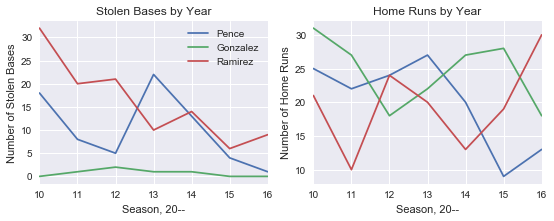

In [9]:
player_comparison.player_comparison(hittersDF)

The graphs above show that player performance can vary dramatically and sometimes inexplicably from season to season. A performance increase in one area does not necessarily lead to an increase in other areas. Hunter Pence's stolen bases varied across the 2010 to 2016 seasons, and so did his home runs. Adrian Gonzalez's stolen bases were consistently near zero for all years, but his home runs jumped up and down. Hanley Ramirez got better at hitting home runs, but stole fewer bases across those same seasons. A decrease in one area does not mean that a player is worse overall; maybe a decrease in stolen bases is a result of more home runs, and thus not being on base to realize base-stealing opportunities. Predictions cannot be made by just looking across years and identifying trends. This makes the fantasy baseball draft selection problem a complicated one as well.

Below are some box plots that provide some information on the distribution of the datasets. The first set is a box plot of the hitters and pitchers DF from 2016. The function used can be found in the "box_plots.py" file.

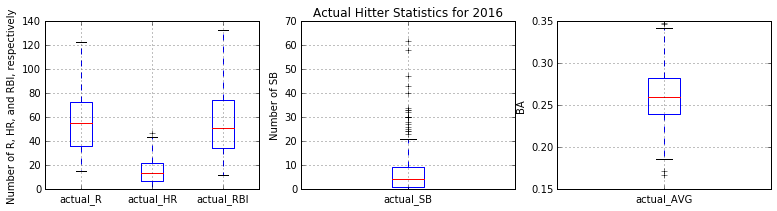

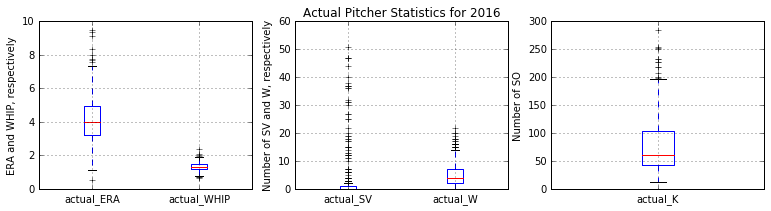

In [77]:
box_plots.box_plots_2016(hittersDF, pitchersDF)

These boxplots demonstrate the distributions of the various hitting and pitching statistics from the 2016 season. Certain statistics are much more prone to outliers than others. Batting average, once we account for the number of at bats, is an example of a statistic that is not very prone to outliers. Stolen bases, on the other hand, have most players fitting in between 0 and 10 bases, while there are several outliers upwards of 20, 30, or even 40. It also demonstrates that when outliers do occur, they most often occur on the upper end of the spectrum for each statistic. It should be noted that other seasons' distributions were similar. We now take a closer look at hitter AVG projections and pitcher K projections, and their distributions for each predictor.

This next set of box plots describes one statistic in each prediction dataframe. The function used can be found in the "box_plots.py" file.

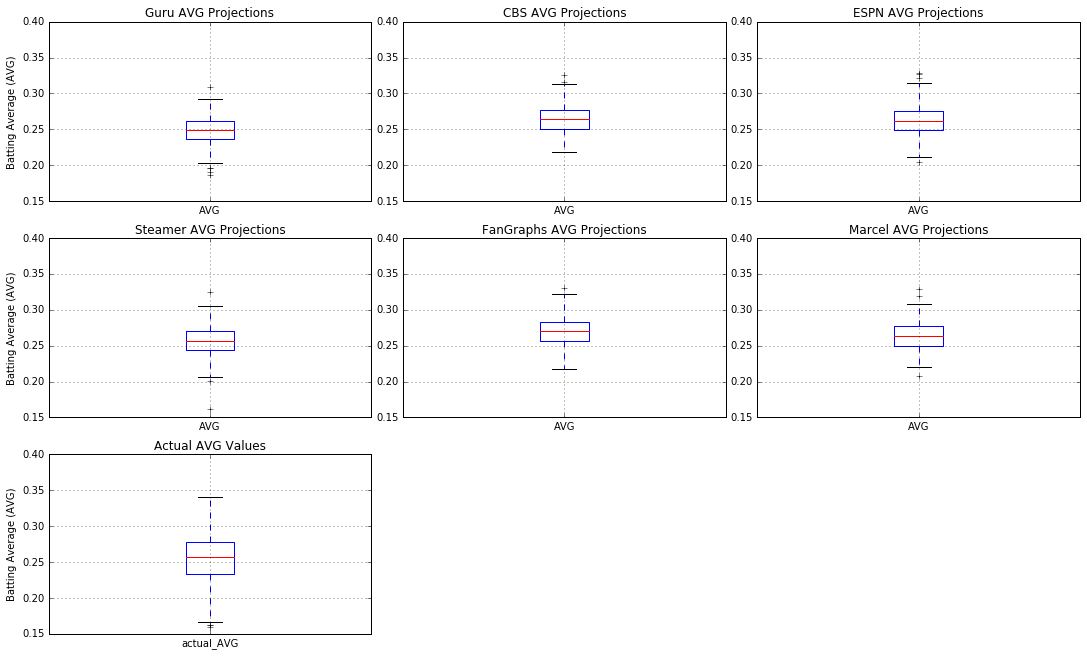

In [79]:
box_plots.box_plots_avg(guru_hitters,cbs_hitters,espn_hitters,steamer_hitters,fangraphs_hitters,marcel_hitters, hittersDF)

While their variances seem fairly similar, we can see a bit of a difference in the way that these different models predict for batting average (AVG). The boxplots above show the different projections for hitters' AVG for the year 2014. FanGraphs doesn't predict as many outliers, while Guru seems to predict the most outliers. FanGraphs also predicted the highest on average, while Guru predicted the lowest on average (this was probably brought down due to the several outliers they predicted to have low batting averages). Overall, however, we see that these prediction methods are very similar in terms of their means and variances. We expect these means and variances to be very close to league means and variances for actual observed batting averages if these projection methods are any good. Indeed, we see from the last box plot that the actual AVG mean is close to the predictor's means. The variance is much larger in the true observed values - this is due to players and circumstances that are perhaps more unexpected, and thus more difficult to predict.

### Determing a "Correct" Prediction

In order to measure the accuracy of a prediction method, we need to determine what a "correct" prediction is. For example, say the prediction of a batter's average is .272 and the actual is .274. Is the prediction wrong or right? Well, it is not exactly correct so in a sense it is wrong, but for practicality purposes this is an extremely useful prediction and will therefore be 'correct' by our standards. We will discuss this idea of a 'correct' prediction later, but for now we will classify every statistic into an epsilon ball of correctness. In the example, we will say a batting average prediction is correct if the prediction is within .01 of the actual.

While there is not an exact science as to how we chose every epsilon ball, we did rely on our previous experience in fantasy baseball and knowledge of players statstics to obtain a general idea as to what would be a useful prediction. Since the ultimate goal of statistical projections is to help us build a fantasy baseball team, we have made this code easy to follow and adjust so the reader may adjust his epsilon ball to be more exact if desired. However, we feel that the epsilon balls will not provide a serious issue for the goals of this project as we will explain and visually show later.

We use two functions below from the file "correct_predictions.py". The first function is "correct_list" which determines the proportion of correct predictions, under predictions, and over predictions. The second function is "plot_correct" which plots these percentages in a bar graph, as shown below.

### Comparing Hitter Projections

Below we plot a graph that will compare the percent of correct predictions for each hitting statistic and each projection method.

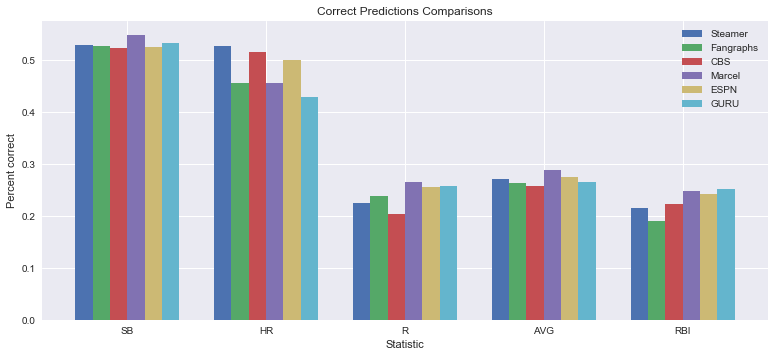

In [17]:
correct_predictions.plot_correct(steamer_pitchers, fangraphs_pitchers, cbs_pitchers, marcel_pitchers, espn_pitchers, guru_pitchers,
                                 steamer_hitters, fangraphs_hitters, cbs_hitters, marcel_hitters, espn_hitters, guru_hitters,)

### Comparing Pitcher Projections

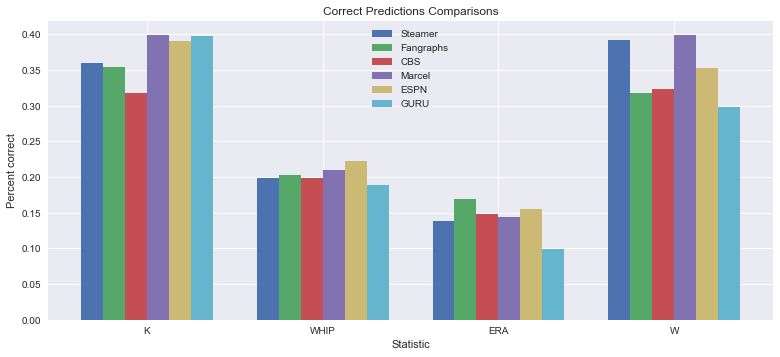

In [18]:
correct_predictions.plot_correct(steamer_pitchers, fangraphs_pitchers, cbs_pitchers, marcel_pitchers, espn_pitchers, guru_pitchers,
                                 steamer_hitters, fangraphs_hitters, cbs_hitters, marcel_hitters, espn_hitters, guru_hitters,
                                 position = 'pitchers')

Here are the important take-aways from these two graphs:
- Given the epsilon balls, nobody does an overly amazing job at predicting (the best being around 50% accuracy). So, it will be important to find a model that can classify if a given projection is correct or not rather than just flipping a coin that ESPN's projection for a given players SB count is correct next year. 
- All the methods seem to be pretty well clumped together - no one method stands out above the rest. 
- Being the 'best' method in one statistic does not guarantee best performance for another statistic. Although ESPN is best for predicting WHIP, it is not the best for ERA. This is useful information as it informs us to run our classifiers on a per stat basis. 
- SB, HR, K, and W are much easier to predict than R, AVG, RBI, ERA, and WHIP. 
    - This is probably due to the fact that SB, HR, K, and W are all integer valued. R and RBI are also integer valued, but they are much more dependent upon teammates' performance. Thus, it is harder to predict those two integer-valued statistics correct as one needs to correctly predict all his teammates' statistics.
    - We expect our classifiers to contain more "correct" classifications for SB, HR, K, and W.

### Plotting ratio of under correct, exactly correct, over correct

As a result of the use of an epsilon ball, there are lots of predictions that are labeled 'correct' yet the prediction is below the actual level or above the actual level, but within the epsilon ball. Below, we call two functions from the "correct_predictions.py" file, which are hitters_ratio_plot and pitchers_ratio_plot. These functions graph the ratio of predictions that are under, exact, and over, but still within the epsilon ball for pitchers and hitters.

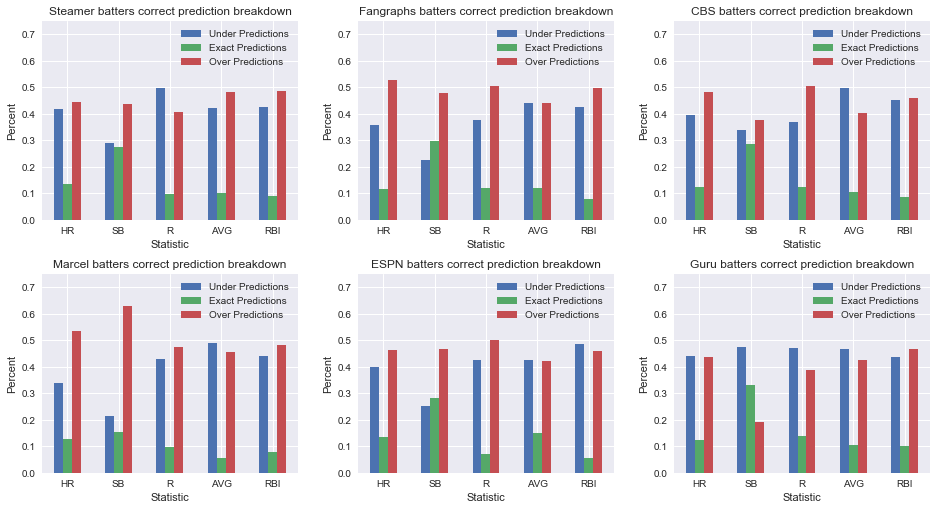

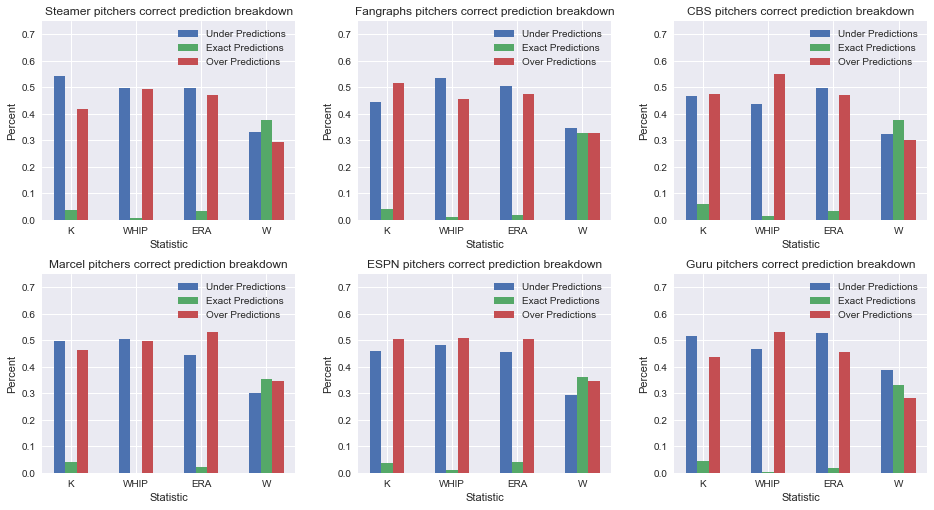

In [14]:
correct_predictions.hitters_ratio_plot(steamer_hitters, fangraphs_hitters, cbs_hitters, marcel_hitters, espn_hitters, guru_hitters)
correct_predictions.pitchers_ratio_plot(steamer_pitchers, fangraphs_pitchers, cbs_pitchers, marcel_pitchers, espn_pitchers, guru_pitchers)

This is a very important set of graphs. These graphs show that the correct predictions are about uniform around the actual value. This means that about half of the correct predictions are below the actual value and half are above. So, the use of the epsilon ball will most likely have a minimal effect on the practicality of our tool. Our projections classified as 'correct' might turn out to be a little below or above the actual value, but over the course of a 30 player team the epsilon ball should average out. The chances of drafting 30 players with 'correct' predictions that are all inside the epsilon ball, but on the lower side, is very unlikely. This justifies our use of an epsilon ball to classify a 'correct' prediction. Again, the epsilon ball can be adjusted.

## Conclusion

This section showed that there is no clear best projection method. Some methods do better at certain stats and worse at others. In addition, none of the methods performed very well with the best percentage of correct predictions being 52% (Steamer - SB). Thus, we have a great opportunity to create a more accurate set of predictions.

# Machine Learning

### Introduction

The most important part of drafting a good fantasy team is to have accurate projections. Our data visualization section showed that for a given statistic, the best accuracy rate of a projection method was only around 50%. This is not very helpful because we don't know which players' predictions are accurate and which are innacurate. So, our goal for this section is to use various classification techniques to determine if a given projection will be correct. Then, given projections for this upcoming year from the six different models, we want to find a correct prediction (or at least the most correct) for each statistic and each player. 

For example: inputs will be Jose Abreu's statistics for last year and each of the 6 sets of his projected statistics for the 2017 season. We will run our best classification model, which we will find in this section through trying different classification models on test/train splits and using CV for the best parameters. After running our best classification model we hope to have results along these lines:

| HR |RBI|SB|AVG|R|
|:-----:|:-----:|:-------:|:-------:|:---:|
| 32 (.56) | 123 (.78)|9 (.43)|.291 (.69)| 105 (.89)|

The parenthetical represents the probability as given by our model that the corresponding value will be a correct prediction. If our model states that more than one projection method will be correct, we will use the projection that the model stated has the highest probability of accuracy. This will be an extremely helpful tool because it will have projections for every player and those projections will have a higher level of accuracy than the projections from any individual method. In order to create this tool, we first need to find a classification model that will accurately classify whether a given projection will be correct or not. That is the purpose of this section.

#### Determining Useful Models

First, we mention some models and algorithms that do not apply to our data and explain why we do not use them here.

Our data contains years (seasons), but they are not time series data. We are not measuring changes over multiple time periods; we are looking at each row of data independent of previous years. So, all the time series and state space methods such as AR, MA, ARMA, ARIMA, and the Kalman filters are not applicable for this classification problem. This is a binary classification problem, so while linear regression and ridge regression are possible, they are sub-optimal compared to a logistic regression.

The logistic regression will be our first model and will establish a baseline for later comparison. After logistic regression, we will discuss and run other classification models such as trees/random forests, gradient boosting/XGBoosting, discriminant analysis, and support vector machine. We also use three algorithms that were not covered in class: Elastic Nets, Passive Aggressive Classifier, and a Voting Classifier. Elastic nets is similar to ridge regression, passive aggressive appears to be an acceptable linear classifier for our data, and the voting classifier will use our previous algorithms and their optimal parameters in hopes of utilizing the various strengths of the different classifiers all together.

#### Model Selection

We incorporate model selection principles throughout the following section by appropriately selecting parameters to plug in for our GridSearchCV implementations, as discussed below.  We are unaware of any particular priors or distributions that our data follows but attempt to find good parameters for each case of machine learning implementation. This takes the place of Bayesian model selection as we evaluate each classification model.

For each of the different machine learning methods, we utilize the GridSearchCV function to find the best parameters to use for optimal predictions.  After that point, we run each machine learning method 10 times for each of the applicable statistics (stored in our to_predict_hitters/pitchers), and each time we use a different train-test split so as to prevent overfitting. Lastly, we take the mean of our prediction accuracies in order to find which method was best at predicting each statistic overall.

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model, metrics, svm, preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier as xgb
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import VotingClassifier

Note: the helper files used in this section are "accuracy_lists.py" and "optimal_parameters.py".

### Logistic Regression

Logistic regression is maybe the most obvious algorithm to try on this type of classification problem, where outputs are binary and inputs are continuous (or at least can be treated as such). This is a fairly simple formulation, and after running a grid search to choose the best cross validation scores, and our results using logistic regression are pretty good for classifying hitter batting average (AVG) predictions (86% accuracy). For homeruns (HR), however, it was only around 63% accuracy, so we at least need to keep searching for a better model on that front. As for classifying pitcher statistic predictions, logistic regression was pretty good for ERA (86%), and not as good for predicting strikeouts (K) at 65%.

Note: The code used to obtain the optimal parameters for pitchers and hitters can be found in the helper file "optimal_parameters.py" Also, the code used to obtain and print the accuracy lists can be found in the helper file "accuracy_lists.py" This will be the same for each classifier used in this section.

In [85]:
logreg_hitters_params = optimal_parameters.lr_hitters_params(to_predict_hitters,x_hitters, hitter_predictions)

In [26]:
accuracy_lists.accuracy_lists_hitters(linear_model.LogisticRegression, logreg_hitters_params, x_hitters, hitter_predictions, to_predict_hitters)

overall average 0.715122628413
correct_AVG     0.719111522443
correct_HR      0.64081443776
correct_R       0.744470152707
correct_RBI     0.765895418788
correct_SB      0.705321610366


In [86]:
logreg_pitchers_params = optimal_parameters.lr_pitchers_params(to_predict_pitchers,x_pitchers, pitcher_predictions)

In [28]:
accuracy_lists.accuracy_lists_pitchers(linear_model.LogisticRegression, logreg_pitchers_params, x_pitchers, pitcher_predictions, to_predict_pitchers)

overall average 0.749423076923
correct_ERA     0.857820512821
correct_K       0.647948717949
correct_W       0.703974358974
correct_WHIP    0.787948717949


### Random Forests

We expect random forests to give better predictions than logistic regression because we do not necessarily know that our data is linear. Random forests do not expect linearly separable data, while logistic regression does. Random forests \ also allow for non-linear interactions between input variables, whereas logistic regression is also not as well-suited to handling categorical features. Here, the model (ESPN, CBS, etc.) is a categorical feature, so we expect random forests to perform better in that regard.

We do not use trees because random forests tend to be a better overall predictor. Random forests provide us with an implementation of many different trees, and ultimately a stronger predictor than a single tree. Our data sets are not so large that require the use of a single tree instead of a random forest. (The same argument for trees applies to decision trees as to why we chose to use random forests instead.) Unfortunately, even with optimized parameters our overall accuracy only improves by ~1%; differences may be more or less for individual statistics.

Note: "Random_Forest_implementation.ipynb" contains details such as importance of coefficients and ROC plots. For the sake of brevity, we do not include these statistics and graphs for all of our classification methods, but you can see an example of them in the notebook mentioned above.

In [29]:
rforest_hitters_params = optimal_parameters.rf_hitters_params(to_predict_hitters,x_hitters, hitter_predictions)

In [30]:
accuracy_lists.accuracy_lists_hitters(RandomForestClassifier, rforest_hitters_params, x_hitters, hitter_predictions, to_predict_hitters)

overall average 0.813317908376
correct_AVG     0.812864414623
correct_HR      0.832068486812
correct_R       0.785886163813
correct_RBI     0.799768625636
correct_SB      0.836001850995


In [31]:
rforest_pitchers_params = optimal_parameters.rf_pitchers_params(to_predict_pitchers, x_pitchers, pitcher_predictions)

In [32]:
accuracy_lists.accuracy_lists_pitchers(RandomForestClassifier, rforest_pitchers_params, x_pitchers, pitcher_predictions, to_predict_pitchers)

overall average 0.760705128205
correct_ERA     0.859615384615
correct_K       0.66358974359
correct_W       0.734102564103
correct_WHIP    0.785512820513


### Gradient Boost/XGBoost

The random forests model is an improvement over logistic regression, but here we implement an XGBoost classifier to hopefully increase our accuracy rates. Boosting can perform better than forests, because boosting finds the weakness (the loss of the previous tree) and uses that information to create a better tree for the next tree in the forest. This creates a tree that is more correlated with the true classification than the previous tree. We decided to use XGBoost rather than gradient boost because XGBoost has a regularization term.

Overall, the XGBoost performed much better than logistic regression, but performed only marginally better than random forests. As with the other methods, XGBoost performed better on the hitting statistics than it did on the pitching statistics. Also, similar to the other models, XGBoost performed best on RBI classification and worst on K classification.

In [33]:
xgb_hitters_params = optimal_parameters.xg_hitters_params(to_predict_hitters,x_hitters, hitter_predictions)

In [34]:
accuracy_lists.accuracy_lists_hitters(xgb, xgb_hitters_params, x_hitters, hitter_predictions, to_predict_hitters)

overall average 0.817936140676
correct_AVG     0.822350763535
correct_HR      0.838685793614
correct_R       0.784544192503
correct_RBI     0.797362332254
correct_SB      0.846737621472


In [35]:
xgb_pitchers_params = optimal_parameters.xg_pitchers_params(to_predict_pitchers, x_pitchers, pitcher_predictions)

In [36]:
accuracy_lists.accuracy_lists_pitchers(xgb, xgb_pitchers_params, x_pitchers, pitcher_predictions, to_predict_pitchers)

overall average 0.762756410256
correct_ERA     0.859871794872
correct_K       0.670897435897
correct_W       0.733974358974
correct_WHIP    0.786282051282


### QDA

We expect quadratic discriminant analysis (QDA) to better predict our variables than LDA because QDA has quadratic boundaries and is better suited for a wider range of problems than linear discriminant analysis. QDA is similar to LDA and both are implementations of GDA; we decided to use QDA as it is a generalization of LDA. We believe the variance of our tables to not be the same, and as such thought QDA would be a more appropriate classifier for our data. We observe that QDA is, in fact, not as accurate for our predictions as random forests. We end up seeing approximately a 74% correct accuracy rate for hitter projections and 70.2% for pitcher projections.

In [37]:
qda_hitters_params = optimal_parameters.qda_hitters_params(to_predict_hitters, x_hitters, hitter_predictions)

In [38]:
accuracy_lists.accuracy_lists_hitters(QuadraticDiscriminantAnalysis, qda_hitters_params, x_hitters, hitter_predictions, to_predict_hitters)

overall average 0.695668671911
correct_AVG     0.704164738547
correct_HR      0.627718648774
correct_R       0.722720962517
correct_RBI     0.748542341509
correct_SB      0.675196668209


In [39]:
qda_pitchers_params = optimal_parameters.qda_pitchers_params(to_predict_pitchers, x_pitchers, pitcher_predictions)

In [40]:
accuracy_lists.accuracy_lists_pitchers(QuadraticDiscriminantAnalysis, qda_pitchers_params, x_pitchers, pitcher_predictions, to_predict_pitchers)

overall average 0.700576923077
correct_ERA     0.793205128205
correct_K       0.64
correct_W       0.666666666667
correct_WHIP    0.702435897436


### SVM

Support vector classification allows us to utilize the kernel trick to transform our data so it is separable (though that may be in another dimension). We use SVM because it performs complex transformations of the data, so we don't have to discover those relationships on our own to take advantage of them.

SVM most accurately classifies hitter AVG statistical projections at 87% and most inaccurately classifiedshitter SB statistical projections at 54%. The polynomial kernel is much worse than the radial basis function kernel. For hitter projections, the SVM classifier with polynomial kernel performs slightly worse than with the RBF kernel for every statistic. For pitcher projections, the SVM classifier with polynomial kernel is right around 50% accuracy for every statistic (this is particularly awful).

In [41]:
svm_hitters_params = optimal_parameters.svm_hitters_params(to_predict_hitters, x_hitters, hitter_predictions)

In [42]:
accuracy_lists.accuracy_lists_hitters(svm.SVC, svm_hitters_params, x_hitters, hitter_predictions, to_predict_hitters)

overall average 0.665164275798
correct_AVG     0.715640906988
correct_HR      0.55210550671
correct_R       0.742387783434
correct_RBI     0.764831096714
correct_SB      0.550856085146


In [43]:
svm_pitchers_params = optimal_parameters.svm_pitchers_params(to_predict_pitchers, x_pitchers, pitcher_predictions)

In [44]:
accuracy_lists.accuracy_lists_pitchers(svm.SVC, svm_pitchers_params, x_pitchers, pitcher_predictions, to_predict_pitchers)

overall average 0.744326923077
correct_ERA     0.860769230769
correct_K       0.634615384615
correct_W       0.697307692308
correct_WHIP    0.784615384615


### Conclusion

Here we have a summary table that contains every statistc and the classification method that had the highest average accuracy rate for that statistic. The parenthetical is the average accuracy rate over 10 trials, where each trial has a new test-train split. 

| HR       |RBI        | SB      |   AVG     |  R       |  ERA          |  K         |WHIP        |W    |
|:-----:|:-----:|:-----:|:------:|:---:|:---:|:---:|:---:|:---:|
|XGBoost (.84)|XGBoost (.81)|XGBoost (.85)|XGBoost (.88)|XGBoost (.84)|Random Forest (.86)|XGBoost (.67)|XGBoost (.79)|Random Forests (.74)|

This table provides a couple of important take-aways:
- Our accuracy for classifying the hitter projections is about 5-10% better than classifying pitcher projections. 
- Clearly, XGBoost and Random Forests are the two most accurate classifiers, but there is no clear overall winner. For many of these statistics, the difference in accuracy between XGBoost and Random Forests was within 1%. In general, XGBoost performs better, but depending on the statistic, we will chose between these two methods when classifying a given prediction.

Our accuracy rates are still not as high as we would like, but are still much better than simply assuming a given prediction of a statistic is correct. For example, Marcel correctly predicts RBIs 55% of the time. So, if you use their predictions, you will be using wrong predictions 45% of the time. However, given a player, statistic of interest, and the six projections, our hope is that our model will classify at least one of the six projections as correct. We then have an 81% surety that this projection is correct, as compared to the 55% accuracy we would get by just assuming a given model is right. Thus, while these results don't seem that useful in their own regard, when compared with the alternative, they provide a much better option.

# New Machine Learning Algorithms

### Elastic Net

We decided to implement elastic net as it is particularly useful when features are correlated with each other, and these statistics are potentially correlated. For instance, the number of wins a pitcher gets is certainly related to his ERA, and likewise his ERA is definitely related to the number of strikeouts he throws. Technically, elastic net, as we implement it here, is another form of logistic regression, but we believe it useful to include.

Logistic regression, as with elastic net, performs best on hitters' batting average (AVG) at around 86% correct classification of projections; it also does well on hitters' runs (R) and pitchers' earned runs (ERA), both at around 79%. The worst classification rate that it gives is 58% on hitters' homeruns (HR) and 58% on pitchers' strikeouts (K). As it turns out, elastic net performs just slightly worse than our logistic regression technique from above (by about 1-5 percent for each statistic). This may have to do with sparsity, as elastic net is also well-suited to deal with sparse data, which ours really aren't. Although elastic net is a little bit worse, the difference isn't very significant. The implementation of logsitic regression with elastic net does not improve our results by any useful measure.

In [45]:
elastic_hitters = new_ML.stoch_grad_hit(to_predict_hitters,x_hitters, hitter_predictions)

In [46]:
accuracy_lists.accuracy_lists_hitters(linear_model.SGDClassifier, elastic_hitters, x_hitters, hitter_predictions, to_predict_hitters)

overall average 0.584581212402
correct_AVG     0.548634891254
correct_HR      0.554789449329
correct_R       0.615085608515
correct_RBI     0.580333179084
correct_SB      0.624062933827


In [47]:
elastic_pitch = new_ML.stoch_grad_pitch(to_predict_pitchers,x_pitchers, pitcher_predictions)

In [48]:
accuracy_lists.accuracy_lists_pitchers(linear_model.SGDClassifier, elastic_pitch, x_pitchers, pitcher_predictions,to_predict_pitchers)

overall average 0.669070512821
correct_ERA     0.82141025641
correct_K       0.565641025641
correct_W       0.669358974359
correct_WHIP    0.619871794872


### Passive Aggressive

The passive aggressive classifier is generally meant for large-scale learning. While our dataframes are not extremely large, we still feel that this is applicable, and it does not require a learning rate. While this classifier does not require a learning rate it still uses a regularization. The classifier essentially updates the algorithm depending on if a previous calculation was correct. The "passive" portion enables the algorithm to keep its current model if it is correct and the "Aggressive" portion updates the model if the classification was incorrect.

Our accuracies from running passive aggressive are not the best of our results.  From one of our sets of 10 runs we receive a low score for 'correct_SB' of 57.7% for hitters with the best accuracy for 'correct_R' with a 75.7%  Pitchers also classify poorly with 52.3% for 'correct_K' and the highest accuracy was for 'correct_ERA' with 78.0%.  Overall, none of these accuracies are better than our previous machine learning algorithms.

In [49]:
pa_hitters = new_ML.pa_hit(to_predict_hitters,x_hitters, hitter_predictions)

In [50]:
accuracy_lists.accuracy_lists_hitters(PassiveAggressiveClassifier, pa_hitters,x_hitters, hitter_predictions, to_predict_hitters)

overall average 0.611735307728
correct_AVG     0.498010180472
correct_HR      0.548033317908
correct_R       0.693937991671
correct_RBI     0.709254974549
correct_SB      0.60944007404


In [51]:
pa_pitchers = new_ML.pa_pitch(to_predict_pitchers,x_pitchers, pitcher_predictions)

In [52]:
accuracy_lists.accuracy_lists_pitchers(PassiveAggressiveClassifier, pa_pitchers, x_pitchers, pitcher_predictions,to_predict_pitchers)

overall average 0.71766025641
correct_ERA     0.852051282051
correct_K       0.582435897436
correct_W       0.658974358974
correct_WHIP    0.777179487179


### Voting Classifier

We chose four of the best classifiers to use in the voting classifier ensemble method: logistic regression, random forest, XGBoost, and QDA. We run a cross validation on the voting classifier to determine the accuracy of the model. If the voting classifier has accuracy close to the others, then we know the individual classifiers tend to make similar classifications.We indeed see that the accuracy percentage of the voting classifier is very similar to the accuracy of XGBoost and random forest and only marginally better than logistic regression and QDA. Thus, we achieve no significant gain by implementing it.

In [54]:
voting_classifier.voting_hitters(to_predict_hitters, hitter_predictions, x_hitters, xgb_hitters_params, rforest_hitters_params, logreg_hitters_params, qda_hitters_params)

 overall average 0.793980908077
correct_AVG     0.788219011739
correct_HR      0.80152455157
correct_R       0.766577166742
correct_RBI     0.787176311888
correct_SB      0.826407498447


In [55]:
voting_classifier.voting_pitchers(to_predict_pitchers, pitcher_predictions, x_pitchers, xgb_pitchers_params, rforest_pitchers_params,logreg_pitchers_params, svm_pitchers_params)

overall average 0.729853989381
correct_ERA     0.859935754208
correct_K       0.662809573198
correct_W       0.613016783965
correct_WHIP    0.783653846154


The "new" algorithms that we implemented here (elastic net, passive aggressive, and voting) did not perform much better (if at all) than the "old" algorithms. Overall, we are still pleased with our results as we are trying to classify statistical projections, which is a difficult problem.

# Results

We set out to produce a final product that will be useful for making predictions for the 2017 season. We will now create two final dataframes - one for hitters and one for pitchers - to meet this goal. Each dataframe will have the player name, a column for each statistical predictions, and a column for the probability that each statistical prediction is correct. The helper file used here is "new_set_of_predictions.py".

In [56]:
x_hitters2017 = pd.read_csv('CSV_files/cleanCSV/x_hitters_2017.csv')
x_pitchers2017 = pd.read_csv('CSV_files/cleanCSV/x_pitchers_2017.csv')
hitter_predictions_2017 = pd.read_csv('CSV_files/cleanCSV/hitter_predictions_2017.csv')
pitcher_predictions_2017 = pd.read_csv('CSV_files/cleanCSV/pitcher_predictions_2017.csv')

In [68]:
best_hitter_predictions, best_pitcher_predictions = new_set_of_predictions.statistic_percentage(xgb_hitters_params,\
                    xgb_pitchers_params, rforest_pitchers_params, hitter_predictions_2017, x_hitters, x_hitters2017, \
                    pitcher_predictions_2017, x_pitchers, x_pitchers2017, pitcher_predictions, hitter_predictions)

In [88]:
best_hitter_predictions[:3]

,Name,AVG,AVG%,HR,HR%,R,R%,RBI,RBI%,SB,SB%
0,a.j. pierzynski,0.251,0.435453,1.0,0.966135,30.0,0.096796,37.0,0.239836,0.0,0.987587
1,aaron hicks,0.249,0.193605,8.0,0.513463,47.0,0.745922,28.0,0.417154,7.0,0.114800
2,aaron hill,0.239,0.446465,6.0,0.981666,46.0,0.099557,46.0,0.224740,2.0,0.983428


In [89]:
best_pitcher_predictions[:3]

,Name,K,K%,ERA,ERA%,W,W%,WHIP,WHIP%
0,a.j. achter,34.0,0.416239,4.48,0.25,2.0,0.690525,1.18,0.398050
1,a.j. cole,61.0,0.291279,4.41,0.30,3.0,0.503492,1.33,0.288711
2,a.j. griffin,76.0,0.202258,5.10,0.30,6.0,0.287537,1.42,0.138362


## Conclusion

We now have two dataframes, one for pitchers and one for hitters, that hold projections for the 2017 season. As mentioned above, this also includes information that sort of defines our confidence in the given prediction. We note that in some cases the probabilities aren't very high, even when our model accuracy is high. In the case of batting average (AVG), for example, this is because the amount of correct predictions was very small to begin with - ESPN was the best at predicting it, and still only predicted it correctly about 10-15% of the time. So, the model could do very well, up to 85-90% accuracy, by always saying the prediction would be wrong. This is true of ERA, R, and WHIP as well. We still think that our model is useful in these cases. With ERA, the five methods we have considered here only predicted 10-15% of all pitchers correctly over the past 5 years. Our model accuracy is higher than any one of these given methods on its own. We take the highest probability prediction as given by our model, and note that we are more certain about this than we would be with any of the methods on their own. 

Note that in the pitcher dataframe above, the result for A.J. Achter predicts a 1.18 WHIP with 39.8% WHIP%, or 'confidence'. This confidence level is pretty low in its own right. However, in the data visualization section above, we showed that ESPN, the best predictor of WHIP among our methods, was only right about 22% of the time. So, in the absence of any other information, we could only be 22% confident in any given ESPN prediction. Our model, though, allows us to get almost double that confidence, which is a lot better. It will be interesting to see how these projections pan out as the 2017 MLB season progresses. We are excited to try to use this information in our own fantasy leagues, and to see if our model is really as useful as we think it is.